<a href="https://colab.research.google.com/github/MiguelAngeloTr/BIGDATA/blob/main/ProyectoFinal/Proyectofinal1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Estudiantes:

*   Miguel Angel Jimenez Trochez - 2215407
*   Juan Pablo Castaño Campo  - 2215929
*   Christian David Cardenas  - 2215689
*   Carlos Alzate Agredo - 2216089

In [ ]:
!pip install -q --upgrade pyspark
!pip install -q findspark
!pip install -q dask-ml
!pip install kagglehub[pandas-datasets]
!pip install -q mlxtend


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import zipfile
import os, pathlib, PIL, shutil, glob
from google.colab import files

import matplotlib.pyplot as plt
from pandas.core.dtypes.api import is_numeric_dtype, is_string_dtype

from pyspark.sql import SparkSession, DataFrame
from pyspark import SparkFiles
import pyspark.sql.functions as F
import pyspark.sql.window as W
import pyspark.sql.types as T

from dask_ml.model_selection import GridSearchCV, RandomizedSearchCV
from dask.distributed import Client

from pyspark.ml.feature import VectorAssembler, MinMaxScaler, StandardScaler, OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.evaluate import confusion_matrix

In [ ]:
client = Client(n_workers=4, threads_per_worker=4)

c:\Users\Chris\AppData\Local\Programs\Python\Python311\Lib\site-packages\distributed\node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 55566 instead
  warnings.warn(


In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bonangelrock","key":"799beae43c9c16dfa76c77a938f1711d"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d shantanugarg274/sales-dataset
!ls

Dataset URL: https://www.kaggle.com/datasets/shantanugarg274/sales-dataset
License(s): CC0-1.0
  0% 0.00/24.0k [00:00<?, ?B/s]
100% 24.0k/24.0k [00:00<00:00, 90.0MB/s]
kaggle.json  sales-dataset.zip	sample_data


In [ ]:
zip_ref = zipfile.ZipFile('sales-dataset.zip', 'r') #localizar el nombre del archivo .zip y colocarlo
zip_ref.extractall('Data') #Extracción de archivos descargados en una carpeta llamada 'files', podria ser cualquier nombre
zip_ref.close()

In [ ]:
spark = SparkSession.builder.appName("KNN - SVM Classification PySpark").getOrCreate()
spark

In [ ]:
datos = spark.read.csv('/content/Data/Sales Dataset.csv',inferSchema=True, header=True)
datos.show(5, truncate=False)

+--------+------+------+--------+-----------+----------------+-----------+----------+-------------+--------+-------+-------------------+
|Order ID|Amount|Profit|Quantity|Category   |Sub-Category    |PaymentMode|Order Date|CustomerName |State   |City   |Year-Month         |
+--------+------+------+--------+-----------+----------------+-----------+----------+-------------+--------+-------+-------------------+
|B-26776 |9726  |1275  |5       |Electronics|Electronic Games|UPI        |2023-06-27|David Padilla|Florida |Miami  |2023-06-01 00:00:00|
|B-26776 |9726  |1275  |5       |Electronics|Electronic Games|UPI        |2024-12-27|Connor Morgan|Illinois|Chicago|2024-12-01 00:00:00|
|B-26776 |9726  |1275  |5       |Electronics|Electronic Games|UPI        |2021-07-25|Robert Stone |New York|Buffalo|2021-07-01 00:00:00|
|B-26776 |4975  |1330  |14      |Electronics|Printers        |UPI        |2023-06-27|David Padilla|Florida |Miami  |2023-06-01 00:00:00|
|B-26776 |4975  |1330  |14      |Electron

In [ ]:
datos.printSchema()

root
 |-- Order ID: string (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Profit: integer (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Category: string (nullable = true)
 |-- Sub-Category: string (nullable = true)
 |-- PaymentMode: string (nullable = true)
 |-- Order Date: date (nullable = true)
 |-- CustomerName: string (nullable = true)
 |-- State: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Year-Month: timestamp (nullable = true)



# Informacion Faltante y Columnas innecesarias


In [ ]:
datos_f1 = datos.drop("Order ID

")
datos_f1.show(10, truncate=False)

+------+------+--------+---------------+----------------+-----------+----------+--------------+----------+-----------+-------------------+
|Amount|Profit|Quantity|Category       |Sub-Category    |PaymentMode|Order Date|CustomerName  |State     |City       |Year-Month         |
+------+------+--------+---------------+----------------+-----------+----------+--------------+----------+-----------+-------------------+
|9726  |1275  |5       |Electronics    |Electronic Games|UPI        |2023-06-27|David Padilla |Florida   |Miami      |2023-06-01 00:00:00|
|9726  |1275  |5       |Electronics    |Electronic Games|UPI        |2024-12-27|Connor Morgan |Illinois  |Chicago    |2024-12-01 00:00:00|
|9726  |1275  |5       |Electronics    |Electronic Games|UPI        |2021-07-25|Robert Stone  |New York  |Buffalo    |2021-07-01 00:00:00|
|4975  |1330  |14      |Electronics    |Printers        |UPI        |2023-06-27|David Padilla |Florida   |Miami      |2023-06-01 00:00:00|
|4975  |1330  |14      |Ele

In [ ]:
def faltantes(df):
  falta = df.select([F.sum(F.col(c).isNull().cast('int')).alias(c) for c in df.columns])
  return falta.show()

In [ ]:
faltantes(datos_f1)

+------+------+--------+--------+------------+-----------+----------+------------+-----+----+----------+
|Amount|Profit|Quantity|Category|Sub-Category|PaymentMode|Order Date|CustomerName|State|City|Year-Month|
+------+------+--------+--------+------------+-----------+----------+------------+-----+----+----------+
|     0|     0|       0|       0|           0|          0|         0|           0|    0|   0|         0|
+------+------+--------+--------+------------+-----------+----------+------------+-----+----+----------+



# Analisis Exploratorio de Datos (EDA)

In [ ]:
numeric_features = [t[0] for t in datos_f1.dtypes if t[1] == 'int' or t[1] == 'double']
datos_f1.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Amount,1194,5178.089614740368,2804.9219551878928,508,9992
Profit,1194,1348.9924623115578,1117.9925725296584,50,4930
Quantity,1194,10.674204355108877,5.777102059828169,1,20


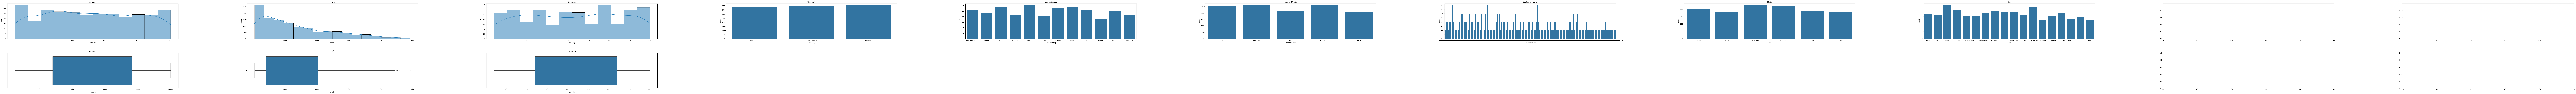

In [ ]:
datos_EDA = datos_f1.toPandas()
num_list = []
cat_list = []

fig, axes = plt.subplots(2, len(datos_EDA.columns), figsize=(300, 10))  # Ajusta el tamaño según sea necesario
fig.subplots_adjust(hspace=0.4, wspace=0.4)

axes = axes.flatten()

# Contador para los gráficos
graph_count = 0

# Iterar sobre las columnas del DataFrame
for column in datos_EDA.columns:
    if is_numeric_dtype(datos_EDA[column]):
        # Histograma en la primera fila
        sns.histplot(datos_EDA[column], kde=True, ax=axes[graph_count])
        axes[graph_count].set_title(f"{column}")

        # Boxplot en la segunda fila
        sns.boxplot(x=datos_EDA[column], ax=axes[graph_count + len(datos_EDA.columns)])
        axes[graph_count + len(datos_EDA.columns)].set_title(f"{column}")
        num_list.append(column)
        graph_count += 1  # Pasar al siguiente gráfico

    elif is_string_dtype(datos_EDA[column]):
        sns.countplot(data=datos_EDA, x=datos_EDA[column], ax=axes[graph_count])
        axes[graph_count].set_title(f"{column}")
        cat_list.append(column)
        axes[graph_count + len(datos_EDA.columns)].axis("off")
        graph_count += 1  # Pasar al siguiente gráfico

# Mostrar la gráfica
plt.show()


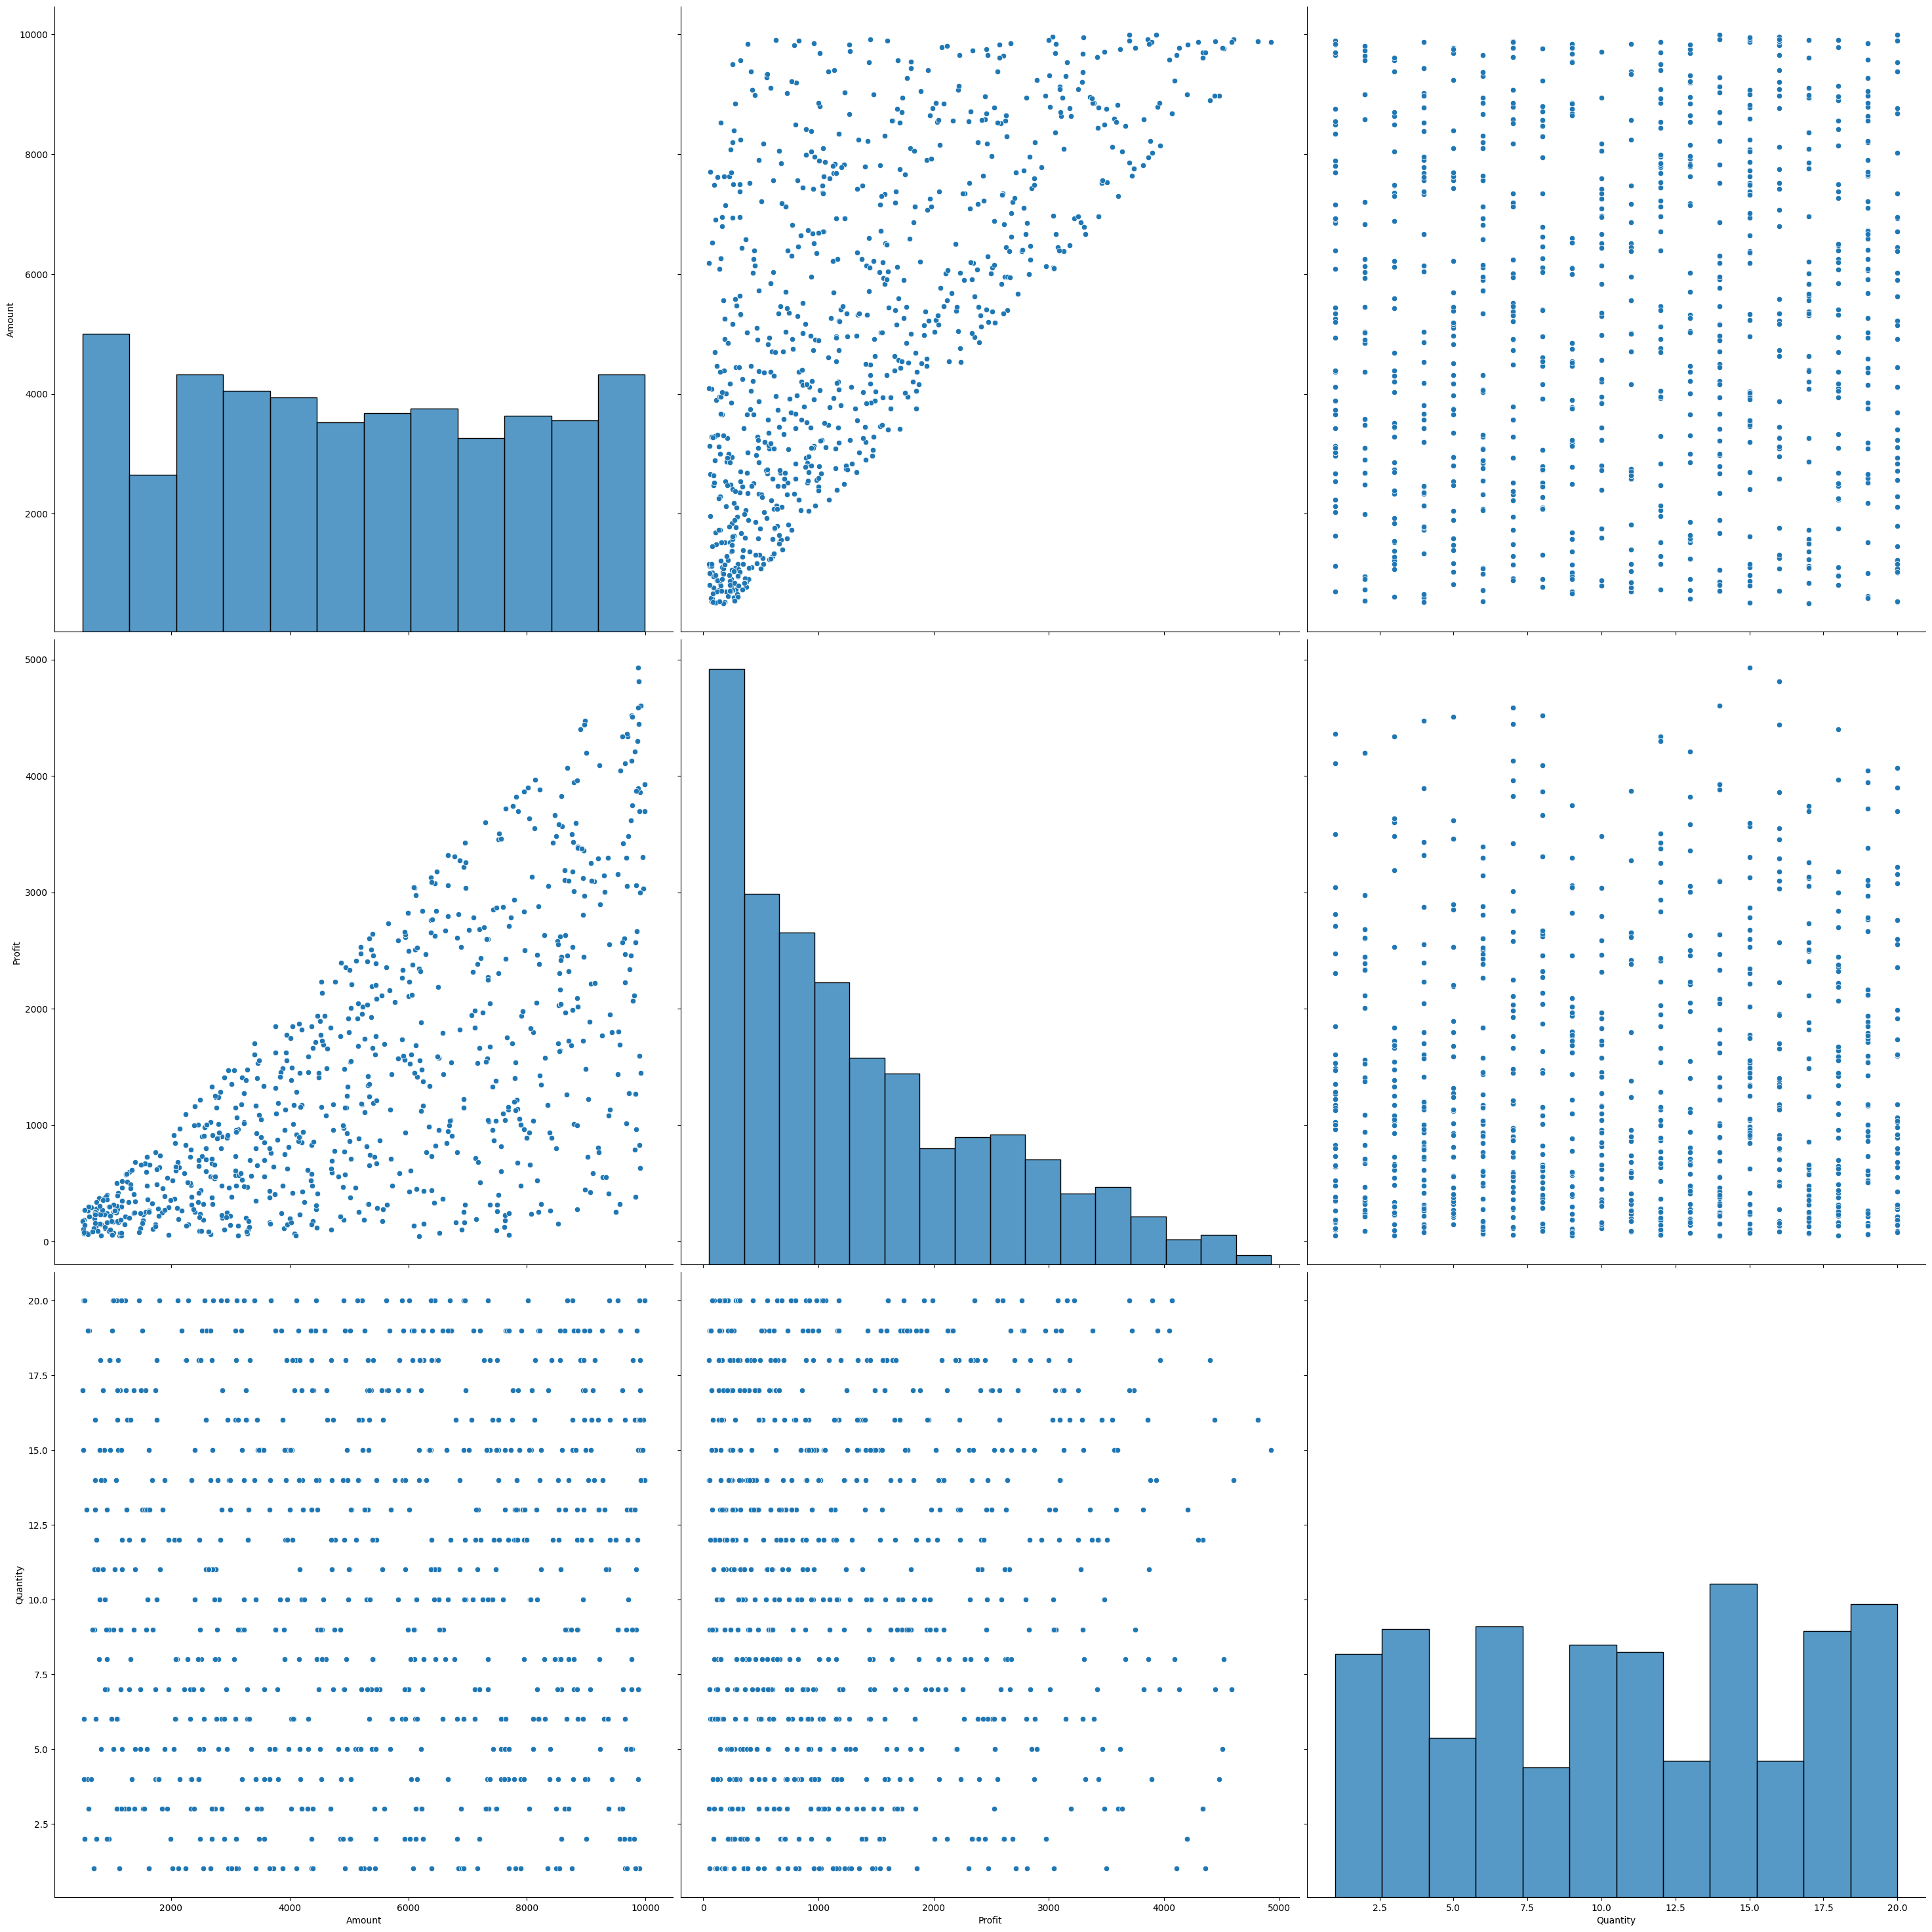

In [ ]:
numeric_data = datos.select(numeric_features).toPandas()
sns.pairplot(numeric_data, height=10)
plt.show()

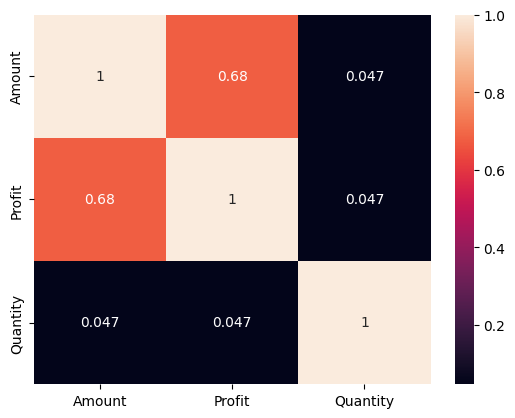

In [ ]:
sns.heatmap(numeric_data.corr('spearman'),annot=True)
plt.show()

Es evidente que no hay variables numéricas altamente correlacionadas. Por lo tanto, las mantendremos todas para el modelo. Aun asi, en la seleccion de variables se descarta nombre del cliente, debido a que no aporta nada al modelo.

In [ ]:
from pyspark.sql.functions import udf
from pyspark.ml.linalg import VectorUDT
from pyspark.sql.types import ArrayType, DoubleType
import pandas as pd

In [ ]:
datos_f2 = datos_f1.select(
    'Order Date', 'City', 'State',
    'Category', 'Sub-Category', 'PaymentMode',
    'Quantity', 'Amount', 'Profit', 'Year-Month'
)

cols = datos_f2.columns
datos_f2.printSchema()




root
 |-- Order Date: date (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Sub-Category: string (nullable = true)
 |-- PaymentMode: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Profit: integer (nullable = true)
 |-- Year-Month: timestamp (nullable = true)



In [ ]:
# Etapa de preprocesamiento

salida = 'Category'
caracteristicas = [car for car in cols if car != salida]

cat = [c for c, t in datos_f2.dtypes if t == 'string' and c != salida]
num = [c for c, t in datos_f2.dtypes if t in ['int', 'double'] and c != salida]

print('Cat:', cat, '\nNum:', num)

indexers = [StringIndexer(inputCol=col, outputCol=f"c_{col}") for col in cat]
encoders = [OneHotEncoder(inputCol=f"c_{col}", outputCol=f"o_{col}") for col in cat]

assembler = VectorAssembler(
    inputCols=num + [f"o_{col}" for col in cat],
    outputCol="features"
)

labelIndexer = StringIndexer(inputCol=salida, outputCol='label') if salida in datos_f2.columns else None


Cat: ['City', 'State', 'Sub-Category', 'PaymentMode'] 
Num: ['Quantity', 'Amount', 'Profit']


In [ ]:
# Pipeline de transformación
stages = indexers + encoders + [assembler]
if labelIndexer:
    stages.append(labelIndexer)

preprocessor = Pipeline(stages=stages).fit(datos_f2)
datos_f3 = preprocessor.transform(datos_f2)



In [ ]:
# Seleccionar solo las columnas necesarias
selectedCols = ['label', 'features']
datos_f4 = datos_f3.select(selectedCols)

# *División de conjuntos de ajuste (entrenamiento) y prueba*


In [ ]:
# Dividir en entrenamiento y prueba
train, test = datos_f4.randomSplit([0.7, 0.3], seed=2024)
print("Training Dataset Count:", train.count())
print("Test Dataset Count:", test.count())

# -------------------------------
# Convertir DenseVector a array
# -------------------------------

train_pd = train.toPandas()
test_pd = test.toPandas()

# Convertir features de DenseVector a arrays usando numpy
import numpy as np

def vector_to_array(vector_col):
    """Convierte una columna de DenseVector a array numpy"""
    return np.array([np.array(row) for row in vector_col])

# Extraer features y labels
X_train = vector_to_array(train_pd['features'])
X_test = vector_to_array(test_pd['features'])
y_train = train_pd['label'].values
y_test = test_pd['label'].values

print("Forma de X_train:", X_train.shape)
print("Forma de y_train:", y_train.shape)

# Aplicar escalado estándar
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



Training Dataset Count: 837
Test Dataset Count: 357
Forma de X_train: (837, 40)
Forma de y_train: (837,)


# *Modelos*
Decidimos aplicar y comparar SVM y KNN como clasificadores supervisados para predecir la categoría de productos en base a características de la transacción. SVM se justifica por su capacidad de manejar datos de alta dimensión y diferentes distribuciones gracias a sus kernels, mientras que KNN se utiliza como modelo no paramétrico y base, útil para capturar patrones complejos sin hacer suposiciones sobre la forma de la frontera de decisión. La comparación permite entender qué tipo de clasificador se ajusta mejor a la naturaleza de nuestros datos de ventas.


# SVC


In [ ]:
from sklearn.svm import SVC
from dask_ml.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Definir el modelo
cls_SVC = SVC()

# Definir el espacio de búsqueda de hiperparámetros

param_grid = {"C": [0.01, 0.1, 1.0, 3.0, 10.0],
              "kernel": ["rbf", "poly", "sigmoid", "linear"]
              }


# Hacer búsqueda aleatoria con validación cruzada

gs_SVC = RandomizedSearchCV(cls_SVC, param_grid, n_iter=10, scheduler=client, random_state=42).fit(X_train, y_train)

# Evaluación del modelo
y_pred = gs_SVC.predict(X_test)

print("Mejores hiperparámetros:", gs_SVC.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))


Mejores hiperparámetros: {'kernel': 'linear', 'C': 3.0}
Accuracy: 1.0
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       113
         1.0       1.00      1.00      1.00       122
         2.0       1.00      1.00      1.00       122

    accuracy                           1.00       357
   macro avg       1.00      1.00      1.00       357
weighted avg       1.00      1.00      1.00       357



# KNN

In [ ]:
cls_KNN = KNeighborsClassifier()
param_grid = {"n_neighbors": range(3,20),
              "p":[1,2],
              "metric":['euclidean','minkowski']}
gs_KNN = RandomizedSearchCV(cls_KNN, param_grid, n_iter=10, scheduler=client, random_state=42).fit(X_train, y_train)
print("Mejores hiperparámetros:", gs_KNN.best_params_)

Mejores hiperparámetros: {'p': 1, 'n_neighbors': 15, 'metric': 'minkowski'}


# Validación

In [ ]:
def calculate_metrics(y_true, y_pred):
    # Calcular otras métricas utilizando sklearn
    accuracy = accuracy_score(y_true, y_pred)*100
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    return {
        "Accuracy (%)": round(accuracy,2),
        "Precision": round(precision,2),
        "Recall": round(recall,2),
        "F1 Score": round(f1,2)
    }

In [ ]:
def conf_matrix(y_pred,y_test):
  fig, ax = plot_confusion_matrix(confusion_matrix(y_test, y_pred), show_normed=True,
                                  figsize=(3,3))
  fig.show()

In [ ]:

test_res_SVC, train_res_KNN = gs_SVC.predict(X_test), gs_KNN.predict(X_train)
train_res_SVC, test_res_KNN = gs_SVC.predict(X_train), gs_KNN.predict(X_test)

# Metricas de rendimiento

Entrenamiento

In [ ]:

print("Métricas en datos de entrenamiento (SVC):\n")
train_metrics = calculate_metrics(train_res_SVC, y_train)
for metric, value in train_metrics.items():
    print(f"{metric}: {value}")

print("\nMétricas en datos de entrenamiento (KNN):\n")
train_metrics = calculate_metrics(train_res_KNN, y_train)
for metric, value in train_metrics.items():
    print(f"{metric}: {value}")

#Sobreajuste extremo (overfitting)
#El modelo memorizó perfectamente los datos.
#Esto puede pasar si el conjunto de test es muy pequeño o muy parecido al de entrenamiento

Métricas en datos de entrenamiento (SVC):

Accuracy (%): 100.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Métricas en datos de entrenamiento (KNN):

Accuracy (%): 86.86
Precision: 0.88
Recall: 0.87
F1 Score: 0.87


C:\Users\Chris\AppData\Local\Temp\ipykernel_356\3659472187.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(None, None)

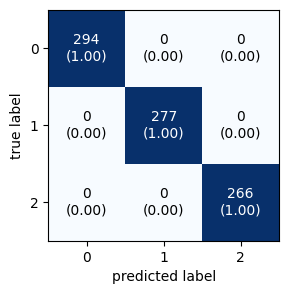

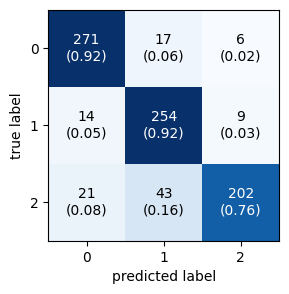

In [ ]:
conf_matrix(train_res_SVC,y_train), conf_matrix(train_res_KNN,y_train)

Prueba

In [ ]:
print("Métricas en datos de prueba (SVC):\n")
test_metrics = calculate_metrics(test_res_SVC,y_test)
for metric, value in test_metrics.items():
    print(f"{metric}: {value}")

print("\nMétricas en datos de prueba (KNN):\n")
train_metrics = calculate_metrics(test_res_KNN, y_test)
for metric, value in train_metrics.items():
    print(f"{metric}: {value}")

Métricas en datos de prueba (SVC):

Accuracy (%): 100.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Métricas en datos de prueba (KNN):

Accuracy (%): 84.87
Precision: 0.86
Recall: 0.85
F1 Score: 0.85


C:\Users\Chris\AppData\Local\Temp\ipykernel_356\3659472187.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(None, None)

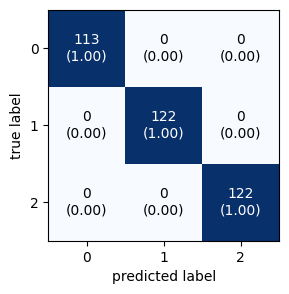

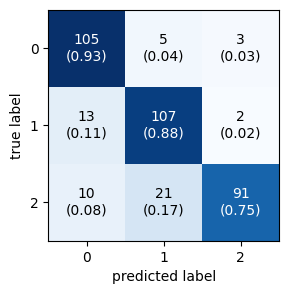

In [ ]:

conf_matrix(test_res_SVC,y_test), conf_matrix(test_res_KNN,y_test)